In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# from fbprophet import prophet
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('PJME_energy_consumption_hourly.csv',index_col=[0],parse_dates=[0])

In [4]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [5]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


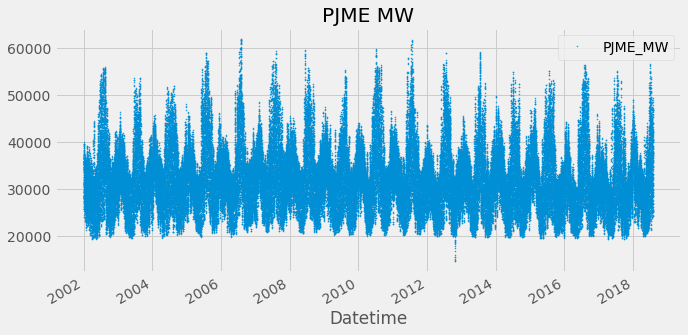

In [6]:
color_pal = sns.color_palette()
df.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='PJME MW')
plt.show()

In [7]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                                        ordered=True )

In [8]:
cat_type

CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                  'Saturday', 'Sunday'],
, ordered=True)

In [9]:
def create_features(df,label=None):
    
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300
    
    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    
    if label:
        y = df[label]
        return X , y
    else :
        return X

In [10]:
x, y = create_features(df, label='PJME_MW')
features_targets = pd.concat([x,y],axis=1)

In [11]:
x

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season
Datetime,,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,Tuesday,Winter
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,Tuesday,Winter
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,Tuesday,Winter
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,Tuesday,Winter
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,Tuesday,Winter
...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,20,0,1,1,2018,1,1,1,Monday,Winter
2018-01-01 21:00:00,21,0,1,1,2018,1,1,1,Monday,Winter
2018-01-01 22:00:00,22,0,1,1,2018,1,1,1,Monday,Winter


In [12]:
y

Datetime
2002-12-31 01:00:00    26498.0
2002-12-31 02:00:00    25147.0
2002-12-31 03:00:00    24574.0
2002-12-31 04:00:00    24393.0
2002-12-31 05:00:00    24860.0
                        ...   
2018-01-01 20:00:00    44284.0
2018-01-01 21:00:00    43751.0
2018-01-01 22:00:00    42402.0
2018-01-01 23:00:00    40164.0
2018-01-02 00:00:00    38608.0
Name: PJME_MW, Length: 145366, dtype: float64

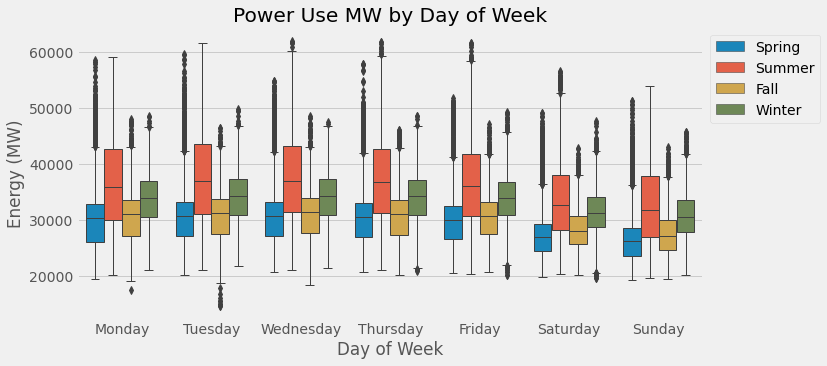

In [13]:
fig,ax = plt.subplots(figsize=(10,5))

sns.boxplot(data=features_targets.dropna(),
           x = 'weekday',
           y = 'PJME_MW',
           hue = 'season',
           ax = ax,
           linewidth=1)

ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

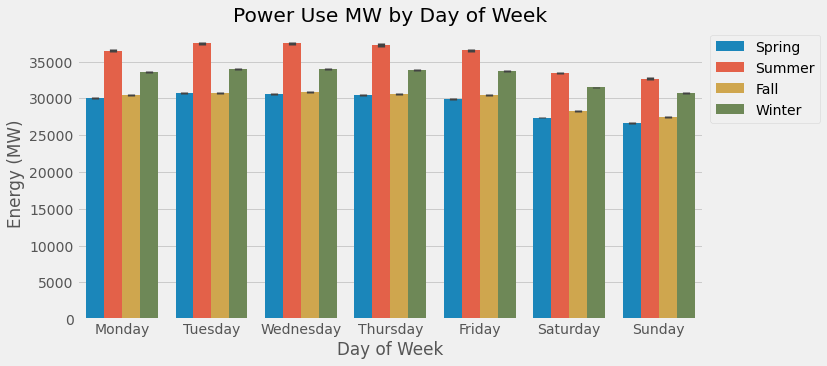

In [14]:
fig,ax = plt.subplots(figsize=(10,5))

sns.barplot(data=features_targets.dropna(),
           x = 'weekday',
           y = 'PJME_MW',
           hue = 'season',
           ax = ax,
           linewidth=1)

ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [15]:
split_date = '1-Jan-2016'

train = df.loc[df.index <= split_date].copy()
test = df.loc[df.index > split_date].copy()

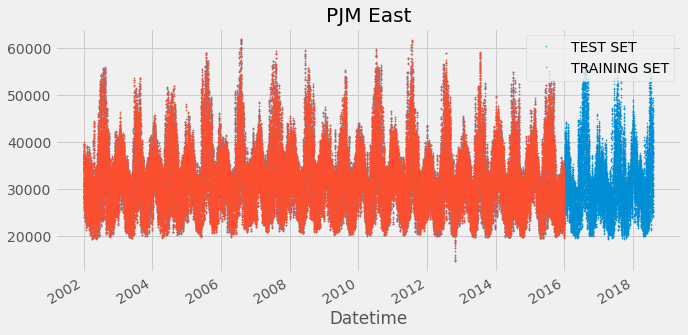

In [16]:
df .rename(columns={'PJME_MW': 'TEST SET'}).join(train.rename(columns={'PJME_MW': 'TRAINING SET'}),
           how='outer').plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()

In [17]:
train_data = train.reset_index().rename(columns={'Datetime':'ds','PJME_MW':'y'})

In [18]:
# model = NeuralProphet()
# model.fit(train_data,freq='D', epochs=1000)